# Homework 3

Cassandra Maldonado

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
import time

### 1. Data Processing

a) Import the data from the website directly

In [2]:
adult_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
                       header=None, skipinitialspace=True)

b) Create column names based on the dataset description

In [3]:
column_names = ["age", "workclass", "fnlwgt", "education", "education-num", 
                "marital-status", "occupation", "relationship", "race", 
                "sex", "capital-gain", "capital-loss", "hours-per-week", 
                "native-country", "salary"]

adult_df.columns = column_names

In [4]:
adult_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


c) Check your dataframe shape to verify that you have the correct # of rows and columns. 
You should get a shape of: (32561, 15)

In [5]:
print("Dataset shape:", adult_df.shape)

Dataset shape: (32561, 15)


d) Drop the 3rd column from the data (it is referred to as "fnlwgt" on UCI's website and is not necessary in this homework)

In [6]:
adult_df = adult_df.drop('fnlwgt', axis=1)

In [7]:
adult_df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


e) Note: There are random values of  '?' that show up in the data - this is fine! These just refer to "unknown" and can be left as is. This data has no true NA values, so no need to check.

f) Use the .replace() method to make the following changes to the "salary" column:

"<=50K" should become 0

">50K" should become 1

Note: This step is essential to calculate the ROC_AUC score in model evaluation steps.

In [8]:
adult_df['salary'] = adult_df['salary'].replace({'<=50K': 0, '>50K': 1})

/var/folders/4g/7cwxt52n09sb7vzyh6tzj3w00000gn/T/ipykernel_58021/909945443.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adult_df['salary'] = adult_df['salary'].replace({'<=50K': 0, '>50K': 1})


In [9]:
print(adult_df['salary'].value_counts())

salary
0    24720
1     7841
Name: count, dtype: int64


g) Create your X dataframe (just your predictors). It should include every feature except for the target variable which is "salary".

You should have the following shape: (32561, 13)

In [10]:
X = adult_df.drop('salary', axis=1)

In [11]:
print("X shape:", X.shape)

X shape: (32561, 13)


h) Create your y dataframe (just your target variable). It should only be "salary".

You should have the following shape: (32561, )

The values should only be 0 and 1.

In [12]:
y = adult_df['salary']

print("y shape:", y.shape)

y shape: (32561,)


In [13]:
#Check values y
print("y values:", y.unique())
print("y value counts:", y.value_counts())

y values: [0 1]
y value counts: salary
0    24720
1     7841
Name: count, dtype: int64


i) For this homework we will try converting columns with factors to separate columns (i.e. one-hot encoding). It is not necessary for trees, but can be a very powerful tool to use. There are a variety of ways to do this, but we can use Pandas built-in method .get_dummies(). Pandas will automatically split out columns that are categorical. For now, just run across your full X dataframe.

Your updated X dataframe should have the following shape: (32561, 107)

In [14]:
X_encoded = pd.get_dummies(X)
print("X_encoded shape:", X_encoded.shape)

X_encoded shape: (32561, 107)


j) Split data into train / test set using an 70/30 split. Verify that you have the same number of columns in your X_train and X_test.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Verifying same number of columns:", X_train.shape[1] == X_test.shape[1])

X_train shape: (22792, 107)
X_test shape: (9769, 107)
Verifying same number of columns: True


### 2. Random Forest Classifier - Base Model:

a) Use the RandomForestClassifier in sklearn. Fit your model on the training data.

In [16]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

b) Use the fitted model to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

In [17]:
# Predicted probabilities
y_prob = rf_model.predict_proba(X_test)[:, 1]
# Predicted classes
y_pred = rf_model.predict(X_test)

print("Predicted probabilities shape:", y_prob.shape)
print("Predicted classes shape:", y_pred.shape)

Predicted probabilities shape: (9769,)
Predicted classes shape: (9769,)


c) Calculate the confusion matrix and classification report (both are in sklearn.metrics).

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[6834  621]
 [ 882 1432]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      7455
           1       0.70      0.62      0.66      2314

    accuracy                           0.85      9769
   macro avg       0.79      0.77      0.78      9769
weighted avg       0.84      0.85      0.84      9769



d) Calculate the AUC score.

In [19]:
auc_score = roc_auc_score(y_test, y_prob)
print(f"\nAUC Score: {auc_score:.4f}")


AUC Score: 0.8889


e) Identify the top 5 features. Feel free to print a list OR to make a plot.

In [20]:
feature_importances = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf_model.feature_importances_
})
top_features = feature_importances.sort_values('importance', ascending=False).head(5)

print("\nTop 5 Features:")
print(top_features)


Top 5 Features:
                              feature  importance
0                                 age    0.220496
4                      hours-per-week    0.113624
2                        capital-gain    0.098573
32  marital-status_Married-civ-spouse    0.076897
1                       education-num    0.067227


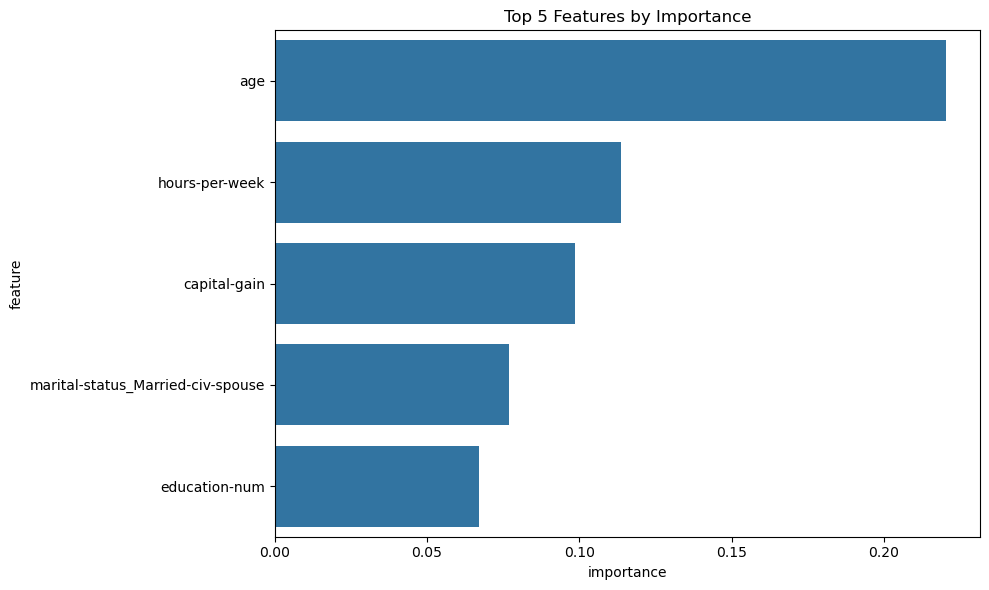

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 5 Features by Importance')
plt.tight_layout()
plt.show()

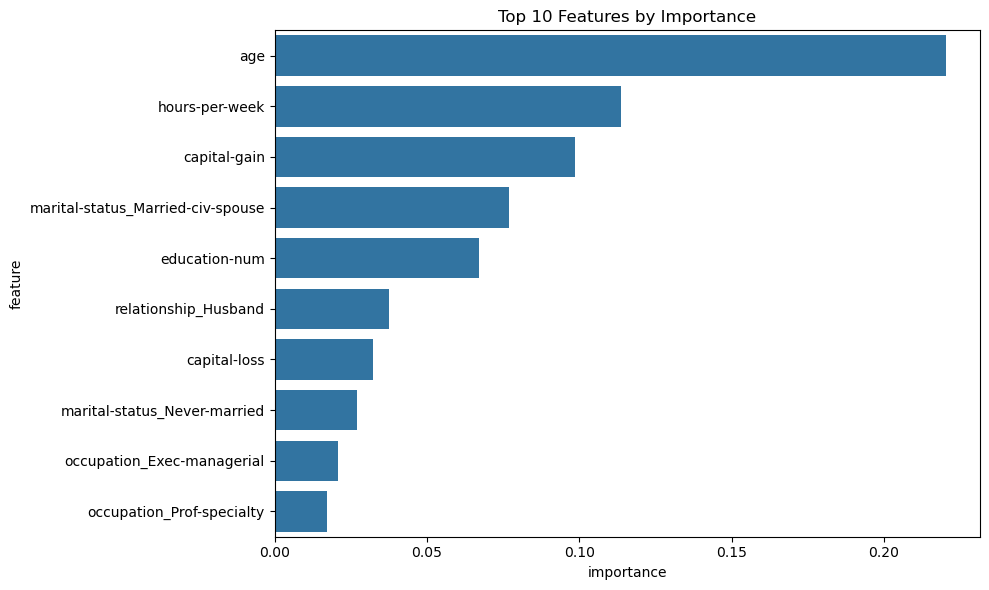

In [22]:
# Top 10 feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.sort_values('importance', ascending=False).head(10))
plt.title('Top 10 Features by Importance')
plt.tight_layout()
plt.show()

f) Using the model from part B, predict for the train data. Look at the classification report for the train data - is there overfitting for the RandomForest model happening?

In [23]:
y_train_pred = rf_model.predict(X_train)
train_report = classification_report(y_train, y_train_pred)

print("\nTraining Data Classification Report:")
print(train_report)


Training Data Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     17265
           1       0.97      0.95      0.96      5527

    accuracy                           0.98     22792
   macro avg       0.98      0.97      0.97     22792
weighted avg       0.98      0.98      0.98     22792



In [24]:
print("\nOverfitting Analysis:")
print("Train F1-score vs Test F1-score")
train_f1 = classification_report(y_train, y_train_pred, output_dict=True)['weighted avg']['f1-score']
test_f1 = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
print(f"Train F1: {train_f1:.4f}")
print(f"Test F1: {test_f1:.4f}")
print(f"Difference: {train_f1 - test_f1:.4f}")
print("Conclusion: " + ("Overfitting is occurring" if (train_f1 - test_f1) > 0.05 else "Minimal overfitting"))


Overfitting Analysis:
Train F1-score vs Test F1-score
Train F1: 0.9809
Test F1: 0.8429
Difference: 0.1380
Conclusion: Overfitting is occurring


- The F1-score combines precision and recall into a single value, providing a balance between the two. It ranges from 0 to 1, where 1 is perfect.

The train F1 is 0.9809, this means that the model performs extremely well here, with a score of 98.09%. On the test F1 the model performs notably worse with a score of 84.29%.
The difference is the gap between training and test performance. A difference of 13.80 % is important. Thus, there is overfitting because the difference exceeds 5%, the threshold  set as a rule of thumb.

To reduce overfitting we could try reducing the complexity of the Random Forest with fewer trees or limited depth. We could also try increasing the minimum samples required at leaf nodes or reducing the number of features considered at each split. Finally, we could try using cross-validation during training and applying regularization techniques.

### 3. AdaBoost Classifier - GridSearch:

a) Use the AdaBoostClassifier along with the GridSearchCV tool. Run the GridSearchCV using the following:

n_estimators: 100, 200, 300, 400

learning_rate: 0.2,0.4,0.6,0.8,1, 1.2

Note: Feel free to try out more parameters, the above is the bare minimum for this assignment.

Use 5 cross-fold and for scoring use "roc_auc" (this is the score that will be referenced when identifying the best parameters).

This run took 8 minutes for your TA.

In [26]:
param_grid_ada = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
}

ada_clf = AdaBoostClassifier(random_state=42)

grid_search_ada = GridSearchCV(
    estimator=ada_clf,
    param_grid=param_grid_ada,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Starting AdaBoost GridSearchCV...")
start_time = time.time()
grid_search_ada.fit(X_train, y_train)
end_time = time.time()
print(f"GridSearchCV completed in {end_time - start_time:.2f} seconds")

print(f"Best parameters: {grid_search_ada.best_params_}")
print(f"Best ROC-AUC score: {grid_search_ada.best_score_:.4f}")

Starting AdaBoost GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

GridSearchCV completed in 37.06 seconds
Best parameters: {'learning_rate': 1.2, 'n_estimators': 400}
Best ROC-AUC score: 0.9253


b) Use the best estimator from GridSearchCV to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

In [27]:
best_ada_model = grid_search_ada.best_estimator_
y_prob_ada = best_ada_model.predict_proba(X_test)[:, 1]
y_pred_ada = best_ada_model.predict(X_test)

c) Calculate the confusion matrix and classification report (both are in sklearn.metrics).

In [28]:
print("\nAdaBoost Confusion Matrix:")
conf_matrix_ada = confusion_matrix(y_test, y_pred_ada)
print(conf_matrix_ada)

print("\nAdaBoost Classification Report:")
print(classification_report(y_test, y_pred_ada))


AdaBoost Confusion Matrix:
[[7008  447]
 [ 807 1507]]

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.77      0.65      0.71      2314

    accuracy                           0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



d) Calculate the AUC score.

In [29]:
auc_score_ada = roc_auc_score(y_test, y_prob_ada)
print(f"\nAdaBoost AUC Score: {auc_score_ada:.4f}")


AdaBoost AUC Score: 0.9244


e) Identify the top 5 features. Feel free to print a list OR to make a plot.

In [30]:
feature_importances_ada = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': best_ada_model.feature_importances_
})
top_features_ada = feature_importances_ada.sort_values('importance', ascending=False).head(5)

print("\nTop 5 Features (AdaBoost):")
print(top_features_ada)


Top 5 Features (AdaBoost):
          feature  importance
2    capital-gain      0.3300
3    capital-loss      0.2900
0             age      0.1075
4  hours-per-week      0.0575
1   education-num      0.0100


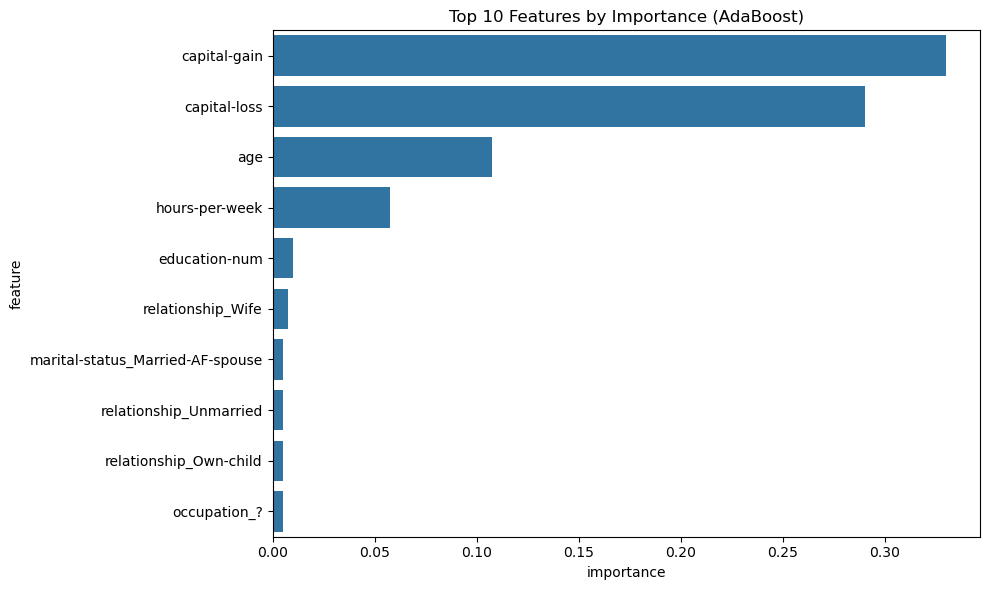

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', 
            data=feature_importances_ada.sort_values('importance', ascending=False).head(10))
plt.title('Top 10 Features by Importance (AdaBoost)')
plt.tight_layout()
plt.show()

f) Using the model from part (b), predict for the train data. Look at the classification report for the train data - is there overfitting for the best estimator?

In [32]:
y_train_pred_ada = best_ada_model.predict(X_train)
print("\nAdaBoost Training Data Classification Report:")
print(classification_report(y_train, y_train_pred_ada))

# Overfitting analysis
train_f1_ada = classification_report(y_train, y_train_pred_ada, output_dict=True)['weighted avg']['f1-score']
test_f1_ada = classification_report(y_test, y_pred_ada, output_dict=True)['weighted avg']['f1-score']

print("\nOverfitting Analysis (AdaBoost):")
print(f"Train F1-score: {train_f1_ada:.4f}")
print(f"Test F1-score: {test_f1_ada:.4f}")
print(f"Difference: {train_f1_ada - test_f1_ada:.4f}")
print("Conclusion: " + ("Overfitting is occurring" if (train_f1_ada - test_f1_ada) > 0.05 else "Minimal overfitting"))


AdaBoost Training Data Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     17265
           1       0.78      0.66      0.71      5527

    accuracy                           0.87     22792
   macro avg       0.84      0.80      0.82     22792
weighted avg       0.87      0.87      0.87     22792


Overfitting Analysis (AdaBoost):
Train F1-score: 0.8679
Test F1-score: 0.8677
Difference: 0.0002
Conclusion: Minimal overfitting


### 4. Gradient Boosting Classifier - GridSearch:

a) Use GradientBoostingClassifier along with the GridSearchCV tool. Run the GridSearchCV using the following hyperparameters:

n_estimators: 100,200, 300 & 400
learning_rate: choose 3 learning rates of your choice
max_depth: 1, 2 (you can try deeper, but remember part of the value of boosting stems from minimal complexity of trees)
Note: Feel free to try out more parameters, the above is the bare minimum for this assignment.

Use 5 cross-fold and for scoring use "roc_auc" (this is the score that will be referenced when identifying the best parameters).

This run took 6.5 minutes for your TA.

In [33]:
param_grid_gb = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.2],  # Chosen three learning rates
    'max_depth': [1, 2]
}

gb_clf = GradientBoostingClassifier(random_state=42)

grid_search_gb = GridSearchCV(
    estimator=gb_clf,
    param_grid=param_grid_gb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Starting Gradient Boosting GridSearchCV...")
start_time = time.time()
grid_search_gb.fit(X_train, y_train)
end_time = time.time()
print(f"GridSearchCV completed in {end_time - start_time:.2f} seconds")

print(f"Best parameters: {grid_search_gb.best_params_}")
print(f"Best ROC-AUC score: {grid_search_gb.best_score_:.4f}")

Starting Gradient Boosting GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearchCV completed in 27.71 seconds
Best parameters: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 400}
Best ROC-AUC score: 0.9284


b) Use the best estimator from GridSearchCV to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

In [34]:
best_gb_model = grid_search_gb.best_estimator_
y_prob_gb = best_gb_model.predict_proba(X_test)[:, 1]
y_pred_gb = best_gb_model.predict(X_test)

c) Calculate the confusion matrix and classification report (both are in sklearn.metrics).

In [35]:
print("\nGradient Boosting Confusion Matrix:")
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
print(conf_matrix_gb)

print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Confusion Matrix:
[[7030  425]
 [ 814 1500]]

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.78      0.65      0.71      2314

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



d) Calculate the AUC score.

In [36]:
auc_score_gb = roc_auc_score(y_test, y_prob_gb)
print(f"\nGradient Boosting AUC Score: {auc_score_gb:.4f}")


Gradient Boosting AUC Score: 0.9259


e) Identify the top 5 features. Feel free to print a list OR to make a plot.


Top 5 Features (Gradient Boosting):
                              feature  importance
32  marital-status_Married-civ-spouse    0.360032
2                        capital-gain    0.219108
1                       education-num    0.173375
3                        capital-loss    0.066789
0                                 age    0.062206


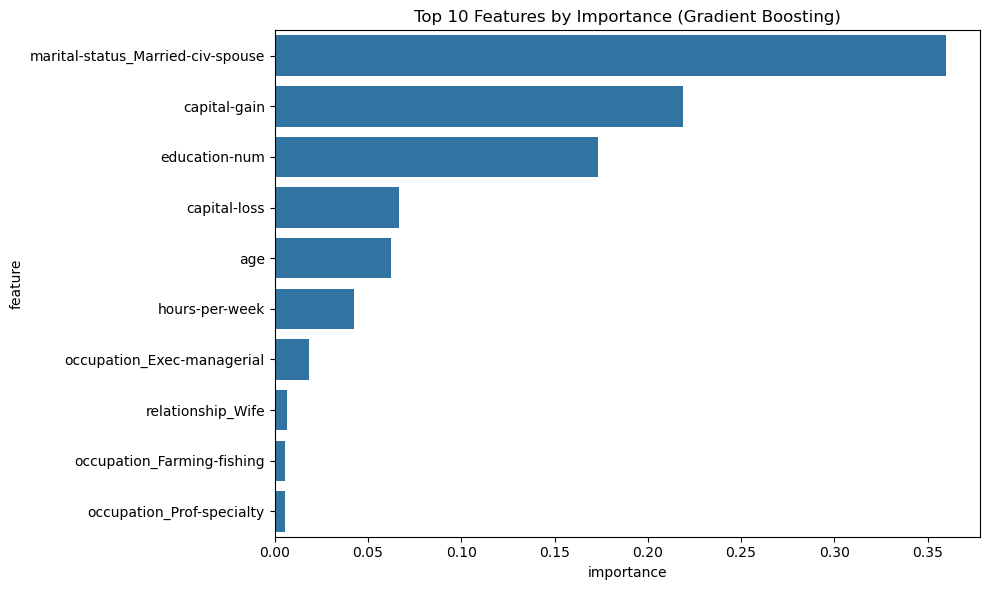

In [37]:
feature_importances_gb = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': best_gb_model.feature_importances_
})
top_features_gb = feature_importances_gb.sort_values('importance', ascending=False).head(5)

print("\nTop 5 Features (Gradient Boosting):")
print(top_features_gb)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', 
            data=feature_importances_gb.sort_values('importance', ascending=False).head(10))
plt.title('Top 10 Features by Importance (Gradient Boosting)')
plt.tight_layout()
plt.show()

f) Using the model from part (b), predict for the train data. Look at the classification report for the train data - is there overfitting for the best estimator?

In [38]:
y_train_pred_gb = best_gb_model.predict(X_train)
print("\nGradient Boosting Training Data Classification Report:")
print(classification_report(y_train, y_train_pred_gb))

# Overfitting analysis
train_f1_gb = classification_report(y_train, y_train_pred_gb, output_dict=True)['weighted avg']['f1-score']
test_f1_gb = classification_report(y_test, y_pred_gb, output_dict=True)['weighted avg']['f1-score']

print("\nOverfitting Analysis (Gradient Boosting):")
print(f"Train F1-score: {train_f1_gb:.4f}")
print(f"Test F1-score: {test_f1_gb:.4f}")
print(f"Difference: {train_f1_gb - test_f1_gb:.4f}")
print("Conclusion: " + ("Overfitting is occurring" if (train_f1_gb - test_f1_gb) > 0.05 else "Minimal overfitting"))


Gradient Boosting Training Data Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     17265
           1       0.81      0.67      0.73      5527

    accuracy                           0.88     22792
   macro avg       0.85      0.81      0.83     22792
weighted avg       0.88      0.88      0.88     22792


Overfitting Analysis (Gradient Boosting):
Train F1-score: 0.8773
Test F1-score: 0.8690
Difference: 0.0084
Conclusion: Minimal overfitting


### 5. XGBoost - RandomizedSearchCV:

Repeat 4(a) - 4(f) with xgboost and RandomizedSearchCV.

For 4a use the following parameters: 

n_estimators: 100-1000 in increments of 50  (i.e. 100,150,200,.....1000)
learning_rate: 0.1 - 1.6 in increments of 0.1
max_depth: 1, 2
gamma: 0 - 5 in increments of 0.25
Note: For parameters with increments please don't feel the need to type each value by hand. There are better ways to handle this. Post in discussion thread if you are struggling.

For RandomizedSearchCV make sure to still use cv = 5 and for scoring use "roc_auc".

In [39]:
import xgboost as xgb

In [40]:
param_dist_xgb = {
    'n_estimators': list(range(100, 1001, 50)),  # 100 to 1000 in increments of 50
    'learning_rate': [x/10.0 for x in range(1, 16)],  # 0.1 to 1.5 in increments of 0.1
    'max_depth': [1, 2],
    'gamma': [x/4.0 for x in range(0, 21)]  # 0 to 5 in increments of 0.25
}

xgb_clf = xgb.XGBClassifier(
    random_state=42,
    objective='binary:logistic',
    eval_metric='auc'
)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist_xgb,
    n_iter=100,  
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("Starting XGBoost RandomizedSearchCV...")
start_time = time.time()
random_search_xgb.fit(X_train, y_train)
end_time = time.time()
print(f"RandomizedSearchCV completed in {end_time - start_time:.2f} seconds")

print(f"Best parameters: {random_search_xgb.best_params_}")
print(f"Best ROC-AUC score: {random_search_xgb.best_score_:.4f}")

Starting XGBoost RandomizedSearchCV...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
RandomizedSearchCV completed in 28.02 seconds
Best parameters: {'n_estimators': 600, 'max_depth': 1, 'learning_rate': 1.3, 'gamma': 0.0}
Best ROC-AUC score: 0.9284


In [41]:
# Best estimator on test data
best_xgb_model = random_search_xgb.best_estimator_
y_prob_xgb = best_xgb_model.predict_proba(X_test)[:, 1]
y_pred_xgb = best_xgb_model.predict(X_test)

# Confusion matrix and classification report
print("\nXGBoost Confusion Matrix:")
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print(conf_matrix_xgb)

print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# AUC score
auc_score_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"\nXGBoost AUC Score: {auc_score_xgb:.4f}")

# Top 5 features
feature_importances_xgb = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': best_xgb_model.feature_importances_
})
top_features_xgb = feature_importances_xgb.sort_values('importance', ascending=False).head(5)

print("\nTop 5 Features (XGBoost):")
print(top_features_xgb)


XGBoost Confusion Matrix:
[[7024  431]
 [ 823 1491]]

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.78      0.64      0.70      2314

    accuracy                           0.87      9769
   macro avg       0.84      0.79      0.81      9769
weighted avg       0.87      0.87      0.87      9769


XGBoost AUC Score: 0.9259

Top 5 Features (XGBoost):
                              feature  importance
32  marital-status_Married-civ-spouse    0.784102
1                       education-num    0.076845
23                education_Bachelors    0.013424
41         occupation_Exec-managerial    0.012662
26                  education_Masters    0.012504


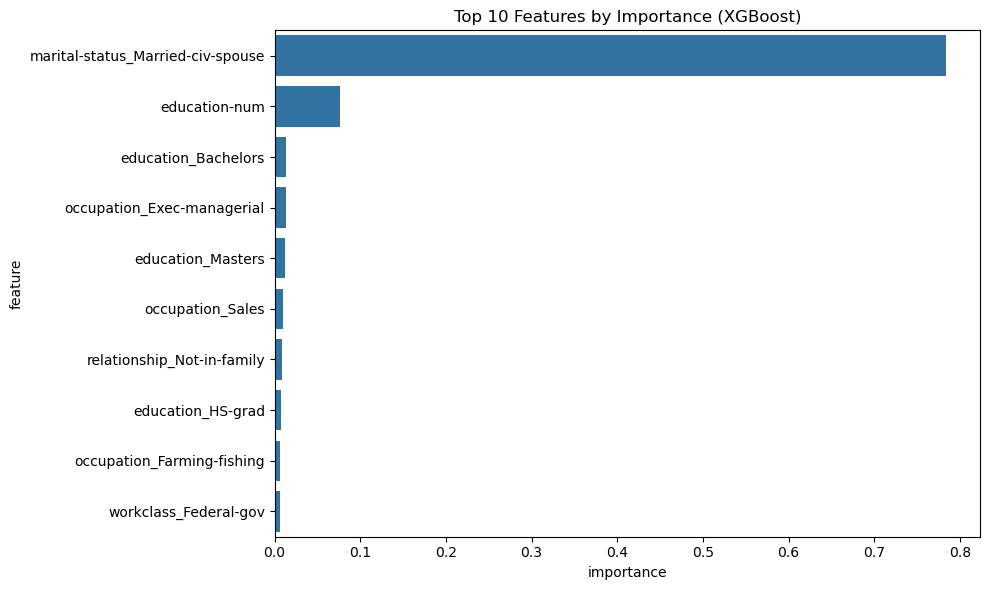


XGBoost Training Data Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     17265
           1       0.79      0.66      0.72      5527

    accuracy                           0.87     22792
   macro avg       0.84      0.80      0.82     22792
weighted avg       0.87      0.87      0.87     22792


Overfitting Analysis (XGBoost):
Train F1-score: 0.8708
Test F1-score: 0.8673
Difference: 0.0035
Conclusion: Minimal overfitting


In [42]:
# Top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', 
            data=feature_importances_xgb.sort_values('importance', ascending=False).head(10))
plt.title('Top 10 Features by Importance (XGBoost)')
plt.tight_layout()
plt.show()

# Overfitting analysis
y_train_pred_xgb = best_xgb_model.predict(X_train)
print("\nXGBoost Training Data Classification Report:")
print(classification_report(y_train, y_train_pred_xgb))

train_f1_xgb = classification_report(y_train, y_train_pred_xgb, output_dict=True)['weighted avg']['f1-score']
test_f1_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)['weighted avg']['f1-score']

print("\nOverfitting Analysis (XGBoost):")
print(f"Train F1-score: {train_f1_xgb:.4f}")
print(f"Test F1-score: {test_f1_xgb:.4f}")
print(f"Difference: {train_f1_xgb - test_f1_xgb:.4f}")
print("Conclusion: " + ("Overfitting is occurring" if (train_f1_xgb - test_f1_xgb) > 0.05 else "Minimal overfitting"))


In [43]:
# Comparison of the models
print("Model Comparison Summary")

models_summary = pd.DataFrame({
    'Model': ['Random Forest', 'AdaBoost', 'Gradient Boosting', 'XGBoost'],
    'Test AUC': [auc_score, auc_score_ada, auc_score_gb, auc_score_xgb],
    'Train F1': [train_f1, train_f1_ada, train_f1_gb, train_f1_xgb],
    'Test F1': [test_f1, test_f1_ada, test_f1_gb, test_f1_xgb],
    'Overfitting': [train_f1 - test_f1, train_f1_ada - test_f1_ada, 
                    train_f1_gb - test_f1_gb, train_f1_xgb - test_f1_xgb]
})

print(models_summary)

Model Comparison Summary
               Model  Test AUC  Train F1   Test F1  Overfitting
0      Random Forest  0.888927  0.980895  0.842872     0.138023
1           AdaBoost  0.924412  0.867916  0.867734     0.000182
2  Gradient Boosting  0.925911  0.877323  0.868963     0.008359
3            XGBoost  0.925863  0.870812  0.867339     0.003473


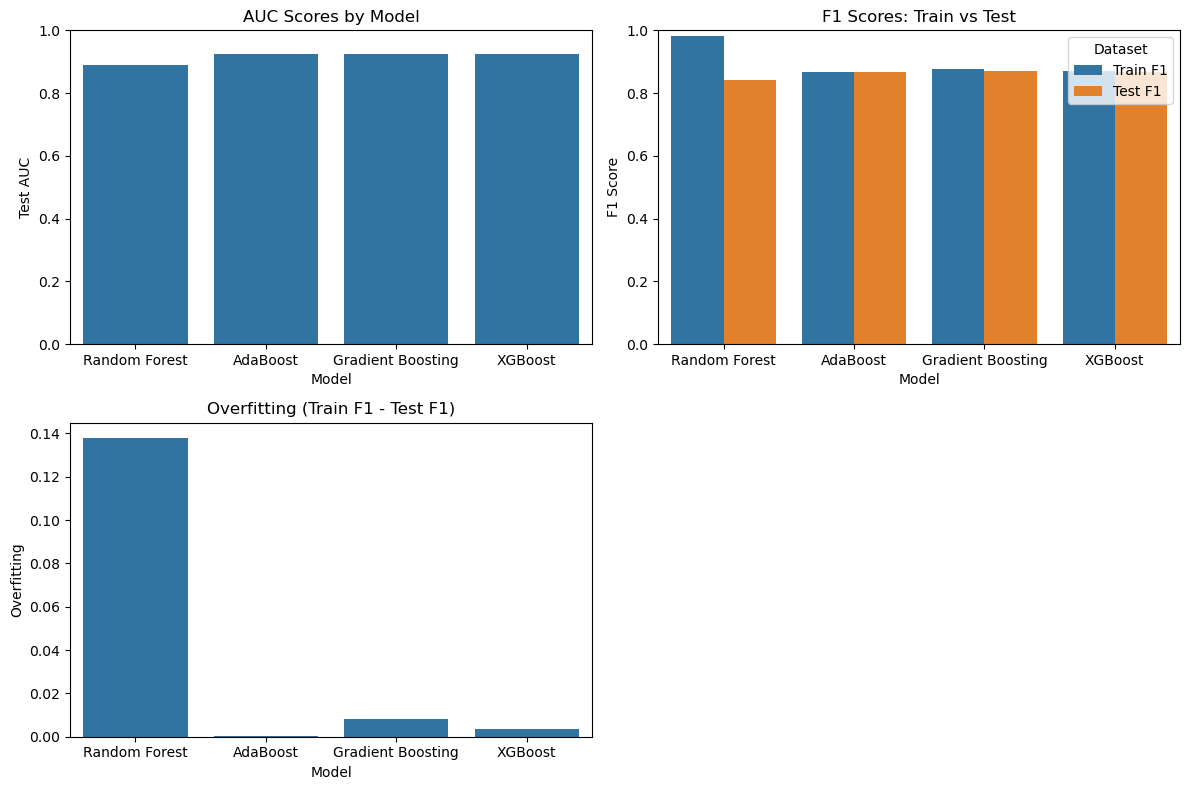

In [44]:
plt.figure(figsize=(12, 8))

# AUC scores
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Test AUC', data=models_summary)
plt.title('AUC Scores by Model')
plt.ylim(0, 1)

# F1 scores
plt.subplot(2, 2, 2)
models_summary_melted = pd.melt(models_summary, id_vars=['Model'], 
                                value_vars=['Train F1', 'Test F1'],
                                var_name='Dataset', value_name='F1 Score')
sns.barplot(x='Model', y='F1 Score', hue='Dataset', data=models_summary_melted)
plt.title('F1 Scores: Train vs Test')
plt.ylim(0, 1)

# Overfitting comparison
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Overfitting', data=models_summary)
plt.title('Overfitting (Train F1 - Test F1)')

plt.tight_layout()
plt.show()

### 6. Moving into Conceptual Problems:

a) The lecture notes describe the Gini Index which is the default criterion used for splitting in sklearn's version of RandomForestClassifier. How does the Gini Index work? (i.e. How is it used to build a top-performing model?). 

_The Gini Index is basically how Random Forest decides where to split data in its decision trees. It measures impurity, whihc is how mixed up different classes are at a node. The formula is Gini = 1 - Σ(pi²), where pi is the probability of each class. When building a tree, the algorithm tries different splits and picks the one that gives the lowest Gini Index, the cleanest separation of classes. A perfect split would give a Gini of 0, meaning all samples in each resulting node belong to the same class. Random Forest does this repeatedly to build each tree, trying to create the most pure groupings possible at each step._

b) Describe how Random Forest is different from bagging & why this difference can yield improved results.

_Both methods create multiple models trained on random samples of the training data, but Random Forest adds an extra trick. While Bagging lets each tree use all features, Random Forest only lets each tree see a random subset of features at each split usually sqrt(n_features) for classification. This is important because:_

_- It makes the trees more independent from each other_

_- It stops dominant features from appearing in every tree_

_-It helps the model find relationships it might miss otherwise_

_This simple change makes Random Forest way more powerful than basic Bagging because the trees are more diverse, so their errors don't all happen in the same places. When one tree messes up, others are likely to get it right, making the combined prediction more reliable._

c) Describe the importance of the max_depth parameter in Random Forest. Do not just provide a definition, rather think through how bias-variance tradeoff might be impacted by the max_depth parameter.

_The max_depth parameter controls how deep each tree can grow in a Random Forest, and it's super important for controlling the bias-variance tradeoff:_

_Small max_depth:_

_-Less complex, make more general predictions._

_-Higher bias, so they might miss important patterns._

_-Lower variance, so it means more stable predictions._

_-Tend to underfit the data._


_Large max_depth:_

_-Super detailed, which means they can model complex relationships._

_-Lower bias, which means they can capture subtle patterns._

_Higher variance, whichs makes it more sensitive to noise in training data._

_-They tend to overfit the data._


_Finding the right depth is hard. Random Forests can handle deeper trees better than single decision trees because the ensemble averaging reduces variance. For our dataset with 107 features, controlling depth is extra important since deep trees might just memorize the training examples instead of learning general patterns._

d)What does the alpha parameter represent in AdaBoost? Please refer to chapter 7 of the Hands-On ML book if you are struggling.

_In AdaBoost, alpha is basically how much voting power each weak classifier gets in the final prediction. Better classifiers get higher alpha values. After training each weak classifier, AdaBoost calculates alpha as:_
_α = 0.5 * ln((1 - error) / error)_

_This means:_

_- A perfect classifier with an error of 0, would get infinite alpha which means unlimited influence_
_- A classifier that's just guessing, for example with an error of 0.5, would get zero alpha which means no influence._
_- A classifier that's always wrong, error of 1, would get negative infinite alpha that means it's useful by doing the opposite of what it predicts_

_This is AdaBoost's way of combining weak models into a strong one._

e) In AdaBoost explain how the final predicted class is determined. Be sure to reference the alpha term in your explanation.

f) In Gradient Boosting, what is the role of the max_depth parameter? Why is it important to tune on this parameter?

g) In Part (e) of Steps 2-5 you determined the top 5 predictors across each model. Do any predictors show up in the top 5 predictors for all three models? If so, comment on if this predictor makes sense given what you are attempting to predict. (Note: If you don't have any predictors showing up across all 3 predictors, explain one that shows up in 2 of them).

h) From the models run in steps 2-5, which performs the best based on the Classification Report? Support your reasoning with evidence from your test data and be sure to share the optimal hyperparameters found from your grid search.

i) For your best performing model, plot out a ROC curve using your test data. Feel free to use sklearn, matplotlib or any other method in python. Describe what the x-axis & y-axis of the ROC curve tell us about a classifier.